# Portfolio constructor
This is a small project which allows the user to construct a portfolio with minimal risk for a desired rate of return, given two assets.
## Step 1: Load the data and clean it
Scan all the time series to find the latest beginning date and earliest ending date. Impute missing values. Put all quotes one after another for later use.

In [151]:
import pandas as pd

assets_filenames = ['.//lkoh.csv', './/lsrg.csv', './/sp500.csv']
assets_n = len(assets_filenames)
tickers = []

assets = pd.DataFrame()

begindate, enddate = (pd.Timestamp('1999-01-01'), pd.Timestamp('2025-01-01'))

for afname in assets_filenames:
    adf = pd.read_csv(filepath_or_buffer=afname, delimiter=';', usecols=[0, 2, 4], parse_dates=[1])
    adf.columns = ['Ticker', 'Date', 'Close']
    tickers.append(adf['Ticker'].iloc[0])
    begindate = max(begindate, adf['Date'].min())
    enddate = min(enddate, adf['Date'].max())

quote_range = pd.date_range(begindate, enddate)

for afname in assets_filenames:
    adf = pd.read_csv(filepath_or_buffer=afname, delimiter=';', usecols=[0, 2, 4], parse_dates=[1])
    adf.columns = ['Ticker', 'Date', 'Close']
    adf = adf.loc[(adf['Date'] >= begindate) & (adf['Date'] <= enddate)]
    adf.set_index('Date', inplace=True)
    adf = adf.reindex(quote_range, method='ffill')
    adf.reset_index(names=['Date'], inplace=True)
    assets = pd.concat([assets, adf])

assets

,Date,Ticker,Close
0,2019-11-11,ЛУКОЙЛ,6048.00
1,2019-11-12,ЛУКОЙЛ,6033.00
2,2019-11-13,ЛУКОЙЛ,6050.00
3,2019-11-14,ЛУКОЙЛ,6084.50
4,2019-11-15,ЛУКОЙЛ,6161.00
...,...,...,...
1823,2024-11-07,S&P 500,5977.20
1824,2024-11-08,S&P 500,5993.60
1825,2024-11-09,S&P 500,5995.54
1826,2024-11-10,S&P 500,5995.54


## Step 2: Add daily Returns
We define daily Returns as a percentage change in price of the asset

In [152]:
assets['Returns'] = assets.groupby('Ticker')['Close'].transform(lambda x: x / x.shift(1) - 1)
assets.dropna(axis=0, inplace=True)
assets.head()

,Date,Ticker,Close,Returns
1,2019-11-12,ЛУКОЙЛ,6033.0,-0.002480
2,2019-11-13,ЛУКОЙЛ,6050.0,0.002818
3,2019-11-14,ЛУКОЙЛ,6084.5,0.005702
4,2019-11-15,ЛУКОЙЛ,6161.0,0.012573
5,2019-11-16,ЛУКОЙЛ,6161.0,0.000000


## Step 2: Find the minimum variance portfolio
Now we need to solve two optimization problems. One optimization with no constraints — global minimum variance portfolio. Another with constraints — find the minimum risk portfolio with a certain required return.

In [153]:
window_size = 10

returns_pivot = assets.pivot(index='Date', columns='Ticker', values='Returns')

returns_pivot = returns_pivot.sort_index()
covm = returns_pivot.rolling(window=window_size).cov()
expected_returns = returns_pivot.rolling(window=window_size).mean()

covm.dropna(axis=0, inplace=True)
expected_returns.dropna(axis=0, inplace=True)

covm

Ticker                   S&P 500        ЛСР ао        ЛУКОЙЛ
Date       Ticker                                           
2019-11-21 S&P 500  8.091170e-06  3.227293e-06  9.335122e-06
           ЛСР ао   3.227293e-06  5.158666e-05 -7.956209e-06
           ЛУКОЙЛ   9.335122e-06 -7.956209e-06  4.352371e-05
2019-11-22 S&P 500  8.158879e-06  5.637162e-07  1.061465e-05
           ЛСР ао   5.637162e-07  1.453482e-05 -5.076477e-07
...                          ...           ...           ...
2024-11-10 ЛСР ао   6.071821e-05  1.458068e-04  3.596964e-05
           ЛУКОЙЛ   5.173434e-05  3.596964e-05  5.639344e-05
2024-11-11 S&P 500  8.108037e-05  6.369553e-05  5.462388e-05
           ЛСР ао   6.369553e-05  9.497077e-05  3.187171e-05
           ЛУКОЙЛ   5.462388e-05  3.187171e-05  5.868202e-05

[5454 rows x 3 columns]

In [154]:
import numpy as np

Date = '2024-10-10'

Rmatrix = expected_returns.loc[Date].values
Covmatrix = covm.loc[Date].values
Wmatrix = np.array([0.3] * assets_n)

Covmatrix

array([[ 4.55395850e-05, -1.84756806e-05, -3.95636883e-05],
       [-1.84756806e-05,  2.90089026e-04,  7.91788042e-05],
       [-3.95636883e-05,  7.91788042e-05,  1.67147962e-04]])

In [155]:
def gen_return(W, R=Rmatrix):
    return np.matmul(W, R)

def gen_std(W, Cov=Covmatrix):
    return np.sqrt(np.matmul(np.matmul(W, Cov), W.transpose()))

def portfolio_performance(W, R, Cov):
    p_ret = gen_return(W, R)
    p_var = gen_std(W, Cov)
    return (p_ret, p_var)

In [156]:
portfolio_performance(Wmatrix, Rmatrix, Covmatrix)

(0.000571356174149491, 0.00700392674831936)

In [157]:
import scipy.optimize

W0 = np.array([0.2] * assets_n)
bounds = [(0, 1) for _ in range(assets_n)]

def sum_of_weights(W):
    h = np.sum(W) - 1

    return h

constraints = ({'type': 'eq', 'fun': sum_of_weights})

opt = scipy.optimize.minimize(fun=gen_std, x0=W0, bounds=bounds, method='SLSQP', constraints=constraints)
print(opt)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.004511710571828442
       x: [ 6.829e-01  3.162e-02  2.855e-01]
     nit: 7
     jac: [ 4.259e-03  4.248e-03  5.145e-03]
    nfev: 28
    njev: 7


In [158]:
W = np.random.dirichlet(np.ones(assets_n), 2000)

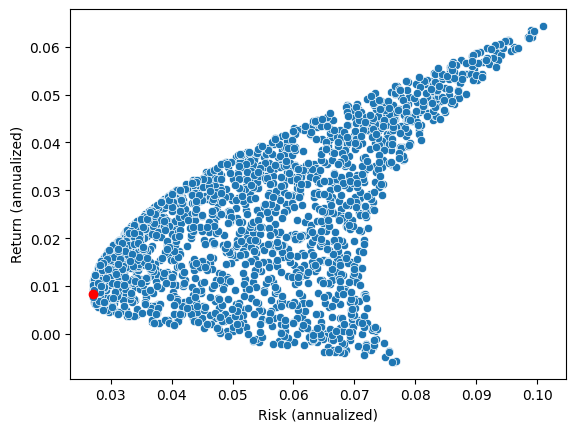

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt

period = 360 / window_size

V = np.multiply(list(map(gen_std, W)), np.sqrt(period))
R = list(map(gen_return, W))
R = np.power(np.add(R, 1), period) - 1

opt_std = gen_std(opt.x) * np.sqrt(period)
opt_ret = (1 + gen_return(opt.x))**period - 1

sns.scatterplot(x = V, y = R)
plt.plot(opt_std, opt_ret, 'ro')
plt.xlabel('Risk (annualized)')
plt.ylabel('Return (annualized)')
plt.show()

In [162]:
W0 = np.array([0.2] * assets_n)
bounds = [(0, 1) for _ in range(assets_n)]

def sum_of_weights(W):
    h = np.sum(W) - 1
    return h

required_return = 0.04

def return_constraint(W):
    g = (1 + gen_return(W))**period - 1 - required_return
    return g

constraints = ({'type': 'eq', 'fun': sum_of_weights}, {'type': 'ineq', 'fun': return_constraint})

opt2 = scipy.optimize.minimize(fun=gen_std, x0=W0, bounds=bounds, method='SLSQP', constraints=constraints)
print(opt2)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.009165690824602715
       x: [ 4.638e-01  5.362e-01  1.388e-17]
     nit: 6
     jac: [ 1.224e-03  1.604e-02  2.630e-03]
    nfev: 24
    njev: 6


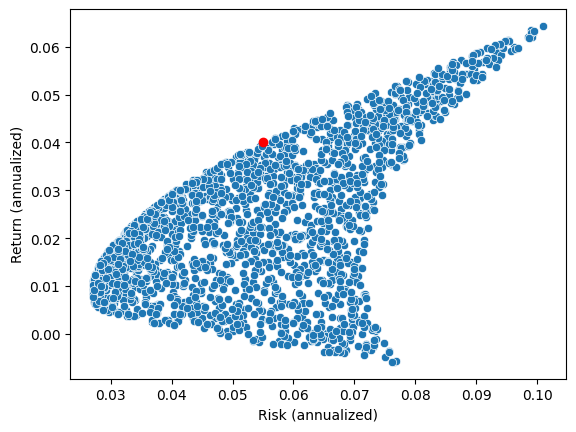

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt


period = 360 / window_size

V = np.multiply(list(map(gen_std, W)), np.sqrt(period))
R = list(map(gen_return, W))
R = np.power(np.add(R, 1), period) - 1

opt2_std = gen_std(opt2.x) * np.sqrt(period)
opt2_ret = (1 + gen_return(opt2.x))**period - 1

sns.scatterplot(x = V, y = R)
plt.plot(opt2_std, opt2_ret, 'ro')
plt.xlabel('Risk (annualized)')
plt.ylabel('Return (annualized)')
plt.show()